In [637]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import random

In [638]:
df0 = pd.read_csv("../input/MissingMigrants-Global-2019-03-29T18-36-07.csv")

# 1. Snapshtot on data

In [639]:
df0.sample(10)

,Web ID,Region of Incident,Reported Date,Reported Year,Reported Month,Number Dead,Minimum Estimated Number of Missing,Total Dead and Missing,Number of Survivors,Number of Females,Number of Males,Number of Children,Cause of Death,Location Description,Information Source,Location Coordinates,Migration Route,URL,UNSD Geographical Grouping,Source Quality
314,51417,Sub-Saharan Africa,"October 23, 2018",2018,Oct,1.0,NaN,1,NaN,NaN,1.0,NaN,Sickness and lack of access to medicines,"Namanga, Tanzania-Kenya border",Mixed Migration Monitoring Mechanism Initiativ...,"-2.552360000000, 36.797570000000",NaN,http://www.mixedmigration.org/4mi/,Eastern Africa,2
4989,40340,Caribbean,"April 11, 2015",2015,Apr,NaN,3.0,3,NaN,1.0,2.0,NaN,Drowning,off the coast of Bahamas,The Tico Times,"25.144970606594, -77.698404023437",NaN,http://bit.ly/1zdmdQ4,Caribbean,1
4516,40453,Mediterranean,"October 28, 2015",2015,Oct,13.0,NaN,13,NaN,NaN,NaN,NaN,Drowning,Found on beaches in Lesvos,Hellenic Coast Guard and IOM Athens,"39.273005000000, 26.423269000000",Eastern Mediterranean,NaN,Uncategorized,5
3521,42639,Central America,"August 03, 2016",2016,Aug,2.0,NaN,2,NaN,NaN,2.0,NaN,Drowning,Nicaragua Lake near the mouth of the Sapoa Riv...,Radio La Primerisima,"11.188704600000, -85.490875000000",Central America to US,http://bit.ly/2aSouKr,Central America,1
2128,43956,US-Mexico Border,"September 14, 2017",2017,Sep,1.0,NaN,1,NaN,NaN,1.0,NaN,Hypothermia,"Pima County, Arizona, USA",Pima County Office of the Medical Examiner,"31.582572200000, -111.861474900000",Central America to US,http://humaneborders.info/,Northern America,5
2231,43747,Sub-Saharan Africa,"August 22, 2017",2017,Aug,1.0,NaN,1,NaN,NaN,1.0,NaN,Sickness and lack of access to medicines,"Agadez, Niger",Mixed Migration Monitoring Mechanism Initiativ...,"17.043769653473, 7.978295253906",NaN,NaN,Western Africa,2
3367,42687,Central America,"September 21, 2016",2016,Sep,1.0,NaN,1,NaN,NaN,1.0,NaN,Fall from train,Train tracks at intersection on Calle de Sur 2...,La Prensa,"18.268156600000, -95.896946100000",Central America to US,http://bit.ly/2cHUhtN,Central America,1
2008,44595,Mediterranean,"October 11, 2017",2017,Oct,4.0,NaN,4,NaN,NaN,NaN,NaN,Presumed drowning,"Bodies recovered off the coast of Sfax, Tunisia",IOM Tunisia,"34.830052608625, 10.869882881250",Central Mediterranean,NaN,Uncategorized,4
4040,43141,North Africa,"March 07, 2016",2016,Mar,2.0,NaN,2,NaN,NaN,NaN,NaN,Sickness and lack of access to medicines,"In the Sahara desert of Aswan, Egypt",Mixed Migration Monitoring Mechanism Initiativ...,"23.459686000000, 30.665449400000",NaN,NaN,Northern Africa,2
2791,30840,Mediterranean,"February 26, 2017",2017,Feb,1.0,NaN,1,NaN,NaN,1.0,NaN,Drowning,"Az-Zawiyah, Libya",Informador,"32.775910100000, 12.697316400000",Central Mediterranean,http://bit.ly/2mzmZTb,Uncategorized,1


### Info on types of data:

In [640]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 20 columns):
Web ID                                 5333 non-null int64
Region of Incident                     5333 non-null object
Reported Date                          5333 non-null object
Reported Year                          5333 non-null int64
Reported Month                         5333 non-null object
Number Dead                            5142 non-null float64
Minimum Estimated Number of Missing    503 non-null float64
Total Dead and Missing                 5333 non-null int64
Number of Survivors                    749 non-null float64
Number of Females                      897 non-null float64
Number of Males                        2813 non-null float64
Number of Children                     644 non-null float64
Cause of Death                         5333 non-null object
Location Description                   5323 non-null object
Information Source                     5331 non-null o

## - Utilize only useful columns for EDA

In [641]:
df = df0[['Web ID','Region of Incident',
         'Reported Date', 
         'Total Dead and Missing',
         'Number of Survivors', 
        'Cause of Death',
        'Location Description',
        'Information Source',
        'Migration Route',
        'URL','UNSD Geographical Grouping']]

## 2. DATA CLEANSING

Data Cleansing will involve below steps:
    1. remove duplicated rows if any
    2. change format of column 'Reported Date' to datetime format
    3. treat unexplanable entries(i.e. 0 victims under column 'Total Dead and Missing' but Number of Survivors is unknown )

In [642]:
#check if there are duplicated rows
df[df['Web ID'].duplicated()]

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Location Description,Information Source,Migration Route,URL,UNSD Geographical Grouping


In [643]:
#change 'Reported Date' column to datetime format
df['Reported Date'] = pd.to_datetime(df['Reported Date'], infer_datetime_format=True)

In [644]:
#Inspect rows with 'Total Dead and Missing' = 0
df[df['Total Dead and Missing']==0]

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Location Description,Information Source,Migration Route,URL,UNSD Geographical Grouping
2485,31060,Mediterranean,2017-06-17,0,NaN,Drowning,"Off the coast of Sabratha, Libya",UNHCR,Central Mediterranean,NaN,Uncategorized
2486,31061,Mediterranean,2017-06-17,0,NaN,Drowning,"Off the coast of Sabratha, Libya",UNHCR,Central Mediterranean,NaN,Uncategorized
3335,42715,Central America,2016-10-04,0,NaN,"Dehydration, Asphyxiation","Back of a truck, Novara, Tres Valles, Veracruz...",La Journada,Central America to US,http://bit.ly/2ds5sdg,Central America
3572,42846,Central America,2016-07-20,0,NaN,Drowning,"Pacific Ocean; Left in boat from San Jose, Chi...",La Tribuna,Central America to US,http://bit.ly/2u8T36K,Central America
3793,42965,Mediterranean,2016-05-25,0,NaN,Drowning,"Off the coast of Zawiya, Libya",UNHCR,Central Mediterranean,NaN,Uncategorized
3996,42959,Mediterranean,2016-03-19,0,NaN,Drowning,NaN,IOM Italy,Central Mediterranean,NaN,Uncategorized
4599,40421,Mediterranean,2015-10-10,0,NaN,Drowning,off the Egyptian port of Baltim,"IOM and Daily Star, AFP report",Central Mediterranean,http://bit.ly/1MmKSlc,Uncategorized
4914,40298,North Africa,2015-06-03,0,NaN,Dehydration,Between Arlit in Niger and Algeria. 67 and 70 ...,IOM Niger,NaN,NaN,Northern Africa
4915,40300,North Africa,2015-06-03,0,NaN,Dehydration,Between Arlit in Niger and Algeria. 67 and 70 ...,IOM Niger,NaN,NaN,Northern Africa
5013,40860,Central America,2015-03-17,0,NaN,Train Accident,"Tabasco state, Mexico",South China Morning Post,Central America to US,http://bit.ly/1CqQVWX,Central America


In [645]:
#Fill 'Total Dead and Missing' according to available URL
df['Total Dead and Missing'][4599]=11
df['Total Dead and Missing'][5013]=6

In [646]:
df.drop(index=df[df['Total Dead and Missing']==0].index,inplace = True)

In [647]:
#add a row to sum 'Total Dead and Missing' and 'Number of Survivors'
df.insert(6,'Total Migrants',0)
df['Total Migrants'] = df['Total Dead and Missing']+df['Number of Survivors']

In [648]:
df.head()

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Total Migrants,Location Description,Information Source,Migration Route,URL,UNSD Geographical Grouping
0,51591,Mediterranean,2019-03-28,2,36.0,Presumed drowning,38.0,"Off the coast of Chios, Greece",Hellenic Coast Guard via IOM Greece,Eastern Mediterranean,NaN,Uncategorized
1,51588,Mediterranean,2019-03-26,4,11.0,Presumed drowning,15.0,"Off the coast of Ayvacık district, Çanakkale p...",Turkish Coast Guard via IOM Turkey,Eastern Mediterranean,http://bit.ly/2YmiPAN,Uncategorized
2,51589,Mediterranean,2019-03-26,1,NaN,Presumed drowning,NaN,"Body recovered on Playa del Tarajal, Ceuta, Sp...","Ceuta al día, El Pueblo de Ceuta",Western Mediterranean,"http://bit.ly/2uyj7qO, http://bit.ly/2uwj5zC",Uncategorized
3,51590,Mediterranean,2019-03-26,1,NaN,Presumed drowning,NaN,"Body recovered on beach near Tetouan, Morocco ...",El Pueblo de Ceuta,Western Mediterranean,http://bit.ly/2uwj5zC,Uncategorized
4,51587,Central America,2019-03-25,1,NaN,Fall from train,NaN,"Train tracks in Teacalco, Tlaxcala, Mexico","Megalópolis, Línea de contraste",NaN,"http://bit.ly/2uvDIvH, http://bit.ly/2TXAFLS",Central America


*For rows with unknown 'Number of Survivors' the total migrants are still unknown

## 1.1. Check cause of deaths of missing migrants

Here below are fill list of cause of death of missing migrants

In [649]:
#check cause of death
df['Cause of Death'].unique()

array(['Presumed drowning', 'Fall from train',
       'Unknown (skeletal remains)', 'Vehicle Accident', 'Violence',
       'Hit by train', 'Drowning', 'Electrocution on railway',
       'Suffocation', 'Cardiac arrest', 'Pneumonia', 'Shot',
       'Pneumonia, Malnutrition', 'Unknown', 'Hit by vehicle',
       'Hypothermia', 'Murdered', 'Fire', 'Dehydration', 'Hit by truck',
       'Unknown (found on dinghy)',
       'Sickness and lack of access to medicines', 'Unknown (violence)',
       'Excessive Physical Abuse, Shot or stabbed',
       'Unknown (multiple blunt force injuries)',
       'Vehicle Accident, Shot or stabbed',
       'Excessive Physical Abuse, Sexual abuse',
       'Sickness and lack of access to medicines, Excessive Physical Abuse, Sexual abuse',
       'Shot or stabbed', 'Vehicle Accident, Excessive Physical Abuse',
       'Fall from vehicle',
       'Sickness and lack of access to medicines, Starvation',
       'Sickness and lack of access to medicines, Dehydration, Har

### Top cause for dead or missing:

In [650]:
df_cause_of_death=df.drop(index=df[df['Total Migrants'].isna()].index)
df_cause_of_death=df_cause_of_death.groupby('Cause of Death').sum()[['Total Dead and Missing','Total Migrants']].sort_values(
    by = 'Total Dead and Missing',ascending = False).reset_index() 

In [651]:
#define sorter
sorter_cause_of_death= list(df_cause_of_death['Cause of Death'].iloc[0:30])


In [652]:
df_cause_of_death1 = pd.melt(df_cause_of_death,id_vars=['Cause of Death'],
        value_vars = ['Total Dead and Missing','Total Migrants'])
df_cause_of_death1 = df_cause_of_death1[df_cause_of_death1['Cause of Death'].isin(sorter_cause_of_death)]
#change to log value
df_cause_of_death1.rename({'value': 'Total(log10)'}, axis=1, inplace=True)
df_cause_of_death1['Total(log10)'] = np.log10(df_cause_of_death1['Total(log10)'])


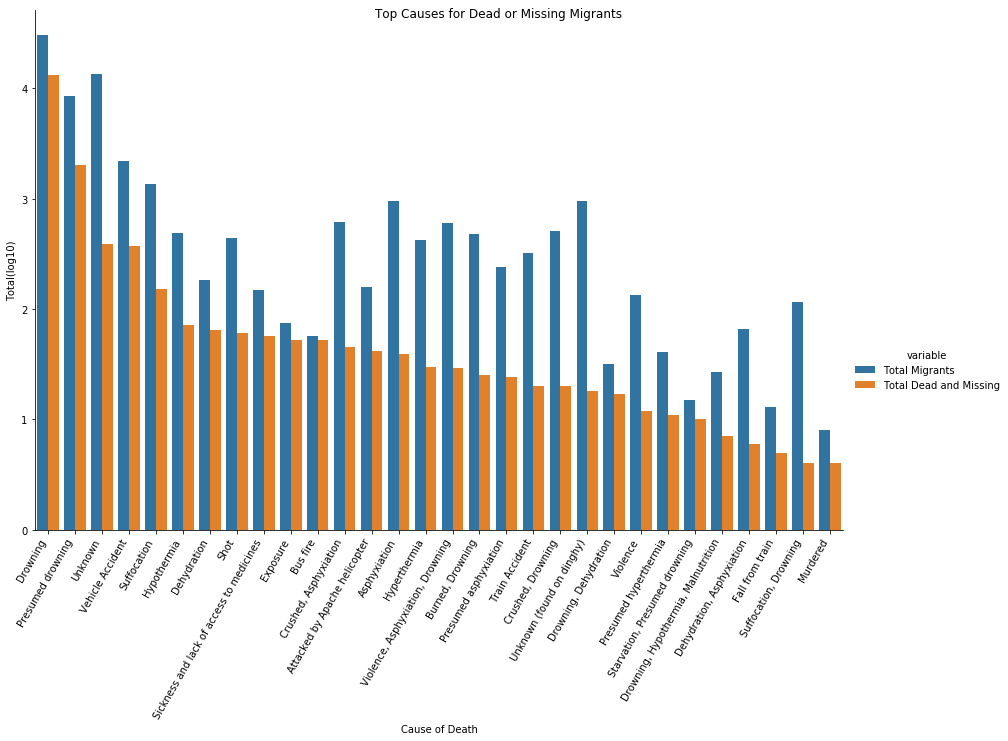

In [653]:
chart = sns.catplot(kind="bar", data = df_cause_of_death1,
            x='Cause of Death',y='Total(log10)',hue = 'variable',
            hue_order = ['Total Migrants','Total Dead and Missing'],
            order = sorter_cause_of_death, height=8,aspect = 1.5)
chart.fig.suptitle('Top Causes for Dead or Missing Migrants')

for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=60,horizontalalignment='right')



In [654]:
df_location = df[df['Cause of Death'].isin(sorter_cause_of_death)]

df_location1 = df_location[['Region of Incident','Cause of Death','Total Dead and Missing']]

df_location1 = df_location1.groupby(['Region of Incident','Cause of Death']).sum().unstack(level=-1)
df_location1.columns = df_location1.columns.droplevel() 
df_location1 = df_location1.fillna(0)


### Number of Cause of Death vs Region of incidents

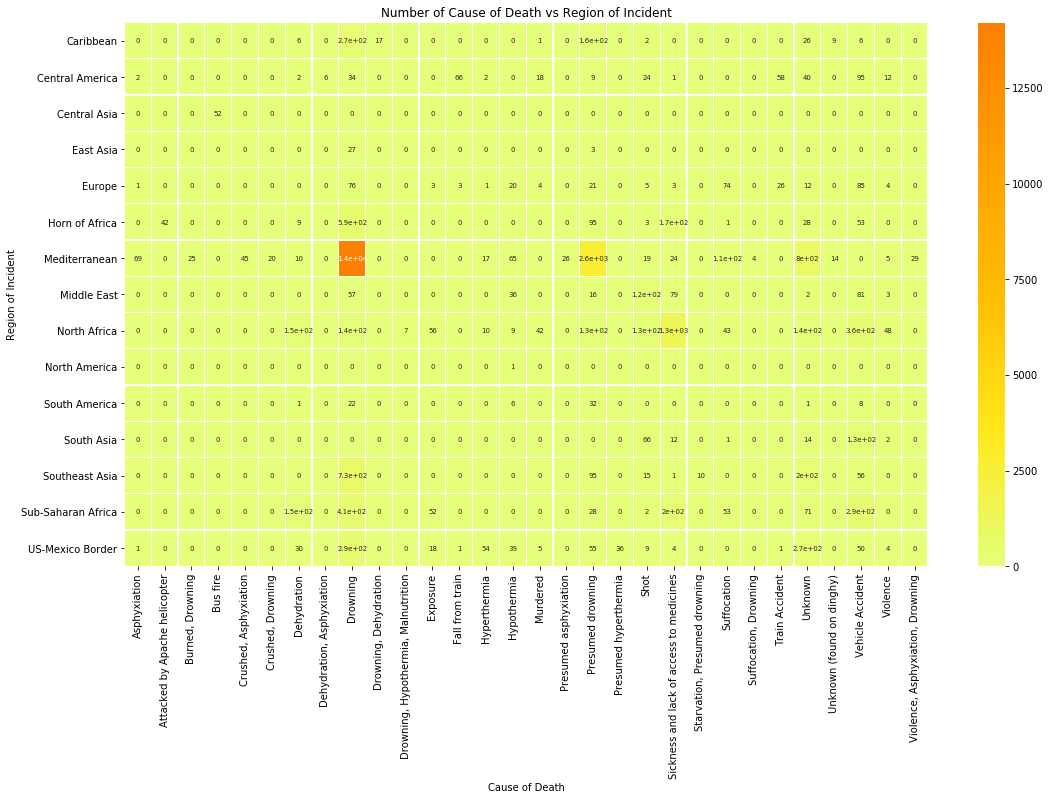

In [655]:
fig, ax = plt.subplots(figsize=(18,10));
sns.heatmap(df_location1,cmap = 'Wistia',annot=True, annot_kws={"size": 7},linewidths=0.25,ax=ax).set_title('Number of Cause of Death vs Region of Incident');

### Table summarizating top cause of death by sum/count of dead and missing, and total migrants

In [656]:
sorter_cause_of_death1= list(df_cause_of_death['Cause of Death'].iloc[0:15])
df_location2 = df[df['Cause of Death'].isin(sorter_cause_of_death1)]
df_location2 = df_location2[['Region of Incident','Cause of Death','Total Dead and Missing','Total Migrants']]
df_location2['Total Migrants'].fillna(df_location2['Total Dead and Missing'],inplace=True)

In [657]:
df_location2_1 = df_location2.groupby('Cause of Death').count()['Total Dead and Missing'].reset_index()
df_location2_1 = df_location2_1.rename({'Total Dead and Missing':'Count of Cases'},axis=1)
df_location2_2 = df_location2.groupby('Cause of Death').sum().reset_index()
df_location2_2 = df_location2_2.rename({'Total Dead and Missing':'Sum of Total Dead and Missing',
                                        'Total Migrants':'Sum of Total Migrants'},axis=1)
df_location2_3 = pd.merge(df_location2_2,df_location2_1,on=['Cause of Death'],how='left')

In [658]:
df_location2_3.sort_values(by = 'Sum of Total Dead and Missing', ascending = False)

,Cause of Death,Sum of Total Dead and Missing,Sum of Total Migrants,Count of Cases
5,Drowning,16863,34338.0,963
9,Presumed drowning,3266,9724.0,347
11,Sickness and lack of access to medicines,1839,1930.0,757
13,Unknown,1592,14600.0,549
14,Vehicle Accident,1210,3006.0,444
10,Shot,391,769.0,171
4,Dehydration,352,473.0,119
12,Suffocation,278,1496.0,36
8,Hypothermia,176,591.0,79
6,Exposure,129,152.0,21


In [659]:
df_location2_3['Sum of Total Dead and Missing'] = np.log10(df_location2_3['Sum of Total Dead and Missing'])
df_location2_3['Sum of Total Migrants'] = np.log10(df_location2_3['Sum of Total Migrants'])
df_location2_3.rename({'Sum of Total Dead and Missing':'Sum of Total Dead and Missing(log10)','Sum of Total Migrants':'Sum of Total Migrants(log10)' },axis=1,inplace=True)

### Visualized explanation

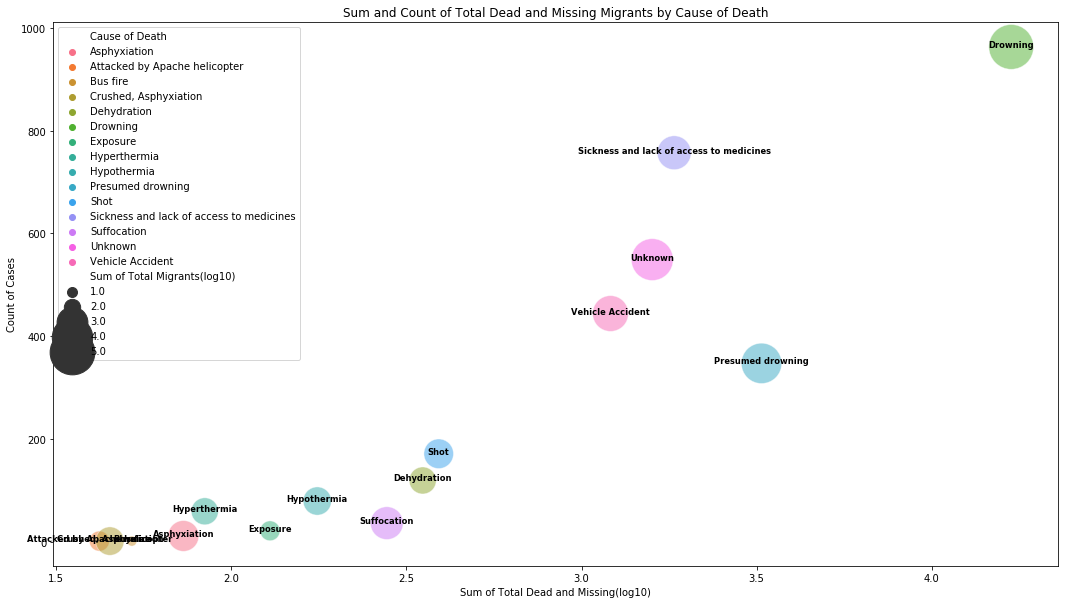

In [660]:
fig, ax = plt.subplots(figsize=(18,10));
ax = sns.scatterplot(x="Sum of Total Dead and Missing(log10)", y="Count of Cases",
                     hue="Cause of Death", size="Sum of Total Migrants(log10)", 
                     sizes=(100, 2000),alpha = 0.5,legend='brief',data=df_location2_3)

for line in range(0,df_location2_3.shape[0]):
     ax.text(x=df_location2_3['Sum of Total Dead and Missing(log10)'][line],
             y= df_location2_3['Count of Cases'][line],
             s=df_location2_3['Cause of Death'][line],
             horizontalalignment='center', size='smaller', color='black', weight='semibold',linespacing=5)
ax.set_title('Sum and Count of Total Dead and Missing Migrants by Cause of Death');

### Let's take one more step to look into the count of number of missing or dead in each drowning cases

In [661]:
#check number of missing or dead in each drowning cases
df_drowning = df[df['Cause of Death']=='Drowning']['Total Dead and Missing']
df_drowning = df_drowning[df_drowning.notna()]

df_drowning = np.log10(df_drowning)

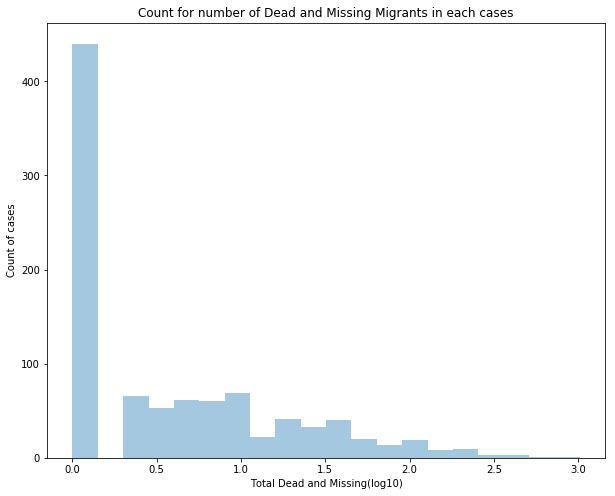

In [662]:
fig, ax = plt.subplots(figsize=(10,8));
sns.distplot(df_drowning,kde = False, ax=ax,bins=20).set_title('Count for number of Dead and Missing Migrants in each cases');
plt.xlabel("Total Dead and Missing(log10)");
plt.ylabel("Count of cases");

## Total Dead and Missing by time

In [663]:
df_temp = df.groupby('Reported Date')['Total Dead and Missing'].sum().reset_index()
df_temp['Reported_Month']=df_temp['Reported Date'].dt.strftime('%Y-%m')
df_temp = df_temp.groupby('Reported_Month')['Total Dead and Missing'].sum().reset_index()

In [664]:
df_temp.head()

,Reported_Month,Total Dead and Missing
0,2014-01,27
1,2014-02,58
2,2014-03,320
3,2014-04,98
4,2014-05,459


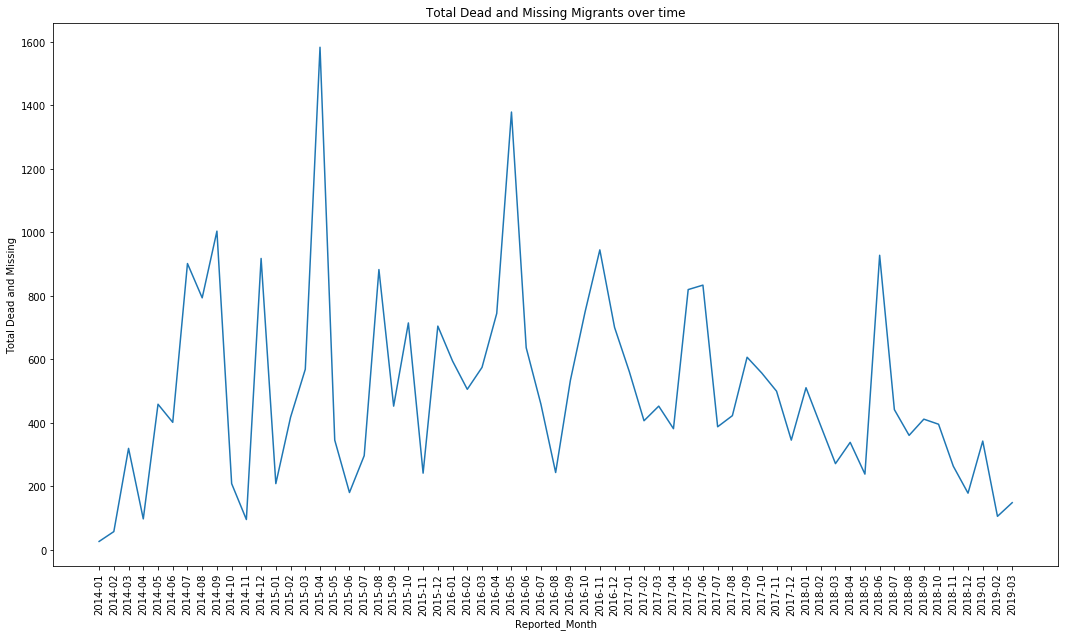

In [665]:
fig,ax =plt.subplots(figsize=(18,10));
ax = sns.lineplot(x="Reported_Month", y="Total Dead and Missing", data=df_temp).set_title('Total Dead and Missing Migrants over time');
plt.xticks(rotation='vertical');